In [1]:
import sys
import os


notebook_dir = os.path.dirname(os.path.realpath("__file__"))  # Path to notebooks directory
parent_dir = os.path.dirname(notebook_dir)  # Parent directory of notebooks

sys.path.append(parent_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from rc.risk_control import rc_main
from img_cls.utils import img_cls_main, max_exit

from img_cls.plot_utils import *
from plotting_style import *

In [3]:
PATH = './data'
DATASET = "imagenet"
MODELS = ['msdnet', 'dvit', 'l2wden',  'dynperc']

LAMBDAS = np.arange(0., 1.001, 0.01)[::-1]  # Descending order
DELTA = 0.1
EPSILONS = np.arange(0.01, 0.51, 0.01)
N_CAL = 100
N_TRIALS = 5
RCP_TYPES = ['ucb-wsr', 'crc']
RISK_TYPES = ['prediction-gt-gap', 'confidence-brier', 'prediction-consistency', 'confidence-brier-top-pred']

In [5]:
PLOT_RES = {}
for model in MODELS:
    for row, risk_type in enumerate(RISK_TYPES):
        print(f"Model: {model}, n_cal: {N_CAL}, risk_type: {risk_type}")
        losses, exits = img_cls_main(model=model, dataset=DATASET, path=PATH, lambdas=LAMBDAS, risk_type=risk_type)
        test_risk, eff_gains, _ = rc_main(losses, exits.mean(axis=1), eps_grid=EPSILONS, rcp_types=RCP_TYPES, 
                                          delta=DELTA, n_cal=N_CAL, n_trials=N_TRIALS, loss_bound=2 if 'brier' in risk_type else 1)
        PLOT_RES[(model, risk_type)] = (test_risk, eff_gains)       

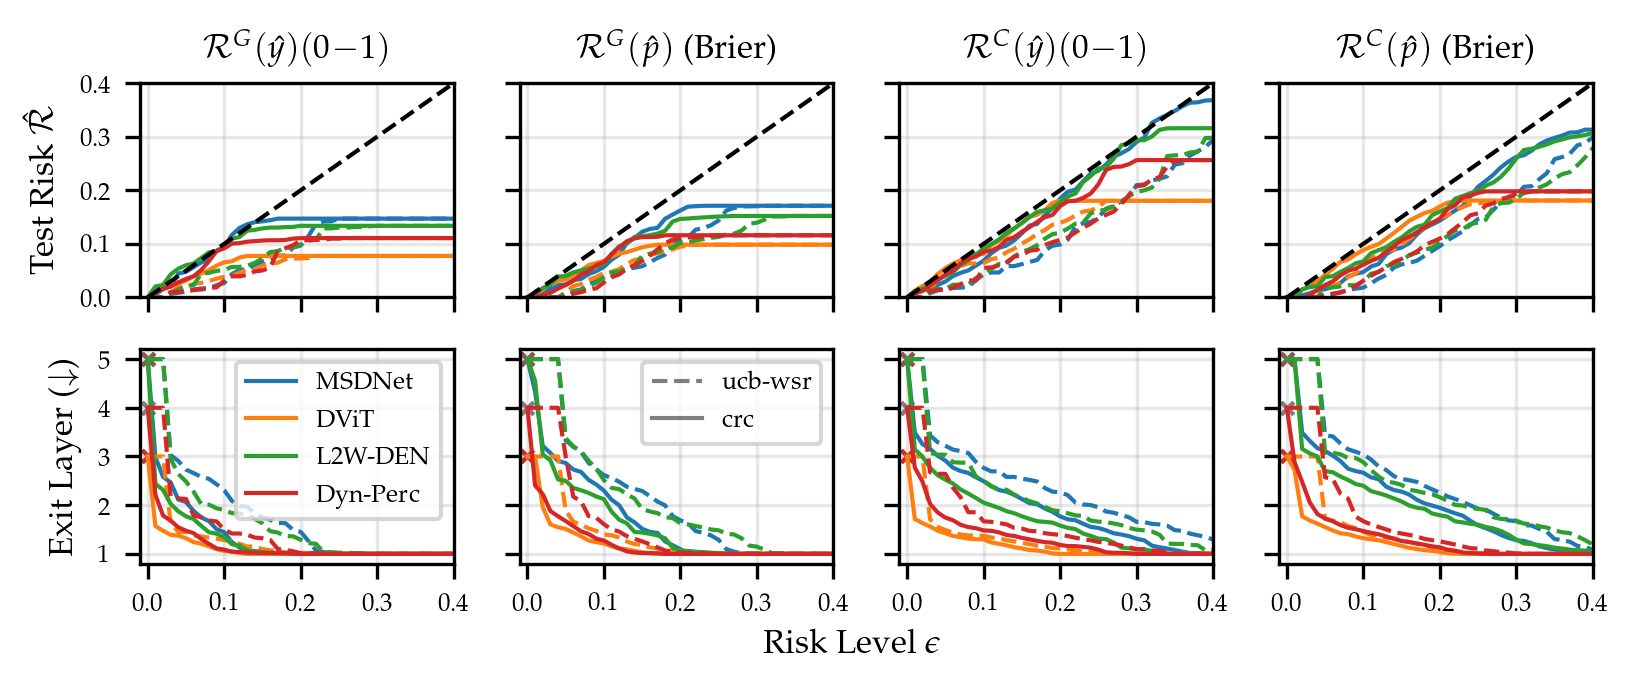

In [9]:
EPS_UPPER = 0.4
_epsilons = np.append(0., EPSILONS)
fig, ax = plt.subplots(2, len(RISK_TYPES), figsize=(text_width, 0.4*text_width), sharex=True)

for j, risk_type in enumerate(RISK_TYPES):
    max_L = 0
    for model in MODELS:
        L = max_exit(model, DATASET, PATH)
        for rcp_type in RCP_TYPES:
            test_risk, eff_gains = PLOT_RES[(model, risk_type)]
            test_risk, eff_gains = np.array(test_risk[rcp_type]), np.array(eff_gains[rcp_type])

            test_risk_mu = np.insert(test_risk.mean(axis=0), 0, 0)
            eff_gains_mu = np.insert(eff_gains.mean(axis=0), 0, L)

            ax[0, j].plot(_epsilons, test_risk_mu, label=model_map[model], color=color_map[model], linestyle=ls_map[rcp_type])
            ax[1, j].plot(_epsilons, eff_gains_mu, label=model_map[model], color=color_map[model], linestyle=ls_map[rcp_type])

            max_L = max(max_L, L)
            ax[1, j].scatter(0, L, marker='x')

    if j > 0:
        ax[0, j].set_yticklabels([])
        ax[1, j].set_yticklabels([])

    ax[0, j].set_xlim(-0.01, EPS_UPPER)
    ax[0, j].set_ylim(0, EPS_UPPER)
    # add a diagonal line
    ax[0, j].plot([0, 1], [0, 1], 'k--')
    ax[1, j].set_yticks([i for i in range(1, int(max_L) + 1)])

    ax[0, j].set_title(risk_map[risk_type])

ax[0, 0].set_ylabel("Test Risk $\hat{\mathcal{R}}$")


ax[1, 0].set_ylabel("Exit Layer ($\downarrow$)")
ax[0, 0].set_xticks([i for i in np.arange(0, EPS_UPPER + 0.1, 0.1)])

ax[1, 0].legend(loc='upper right')


# add legend
lines2 = [Line2D([0], [0], color='black', lw=1, linestyle=ls_map[rcp], alpha=0.5) for rcp in RCP_TYPES]
labels2 = RCP_TYPES

lines1 = [Line2D([0], [0], color=color_map[model], lw=1, linestyle='-',) for model in MODELS]
labels1 = [model_map[model] for model in MODELS]

legend1 = ax[1, 0].legend(lines1, labels1, loc='upper right',)
legend2 = ax[1, 1].legend(lines2, labels2, loc='upper right',)

fig.text(0.52, 0.0, r"Risk Level $\epsilon$", ha='center')

plt.tight_layout()
plt.show()